# Sort results by pupil vairance / first order modulation
* First, plot first order results as fn of pupil variance
* Then, noise corr. as function of pupil / first order
* Decoding as function of pupil / first order
* LV effect as function of pupil / first order

In [1]:
import sys; sys.path.append("/auto/users/hellerc/code/projects/nat_pupil_ms/")
from global_settings import CPN_SITES, HIGHR_SITES
import charlieTools.nat_sounds_ms.decoding as decoding
import charlieTools.nat_sounds_ms.preprocessing as cpreproc
from nems_lbhb.analysis.statistics import get_bootstrapped_sample, get_direct_prob
import load_results as ld
from path_settings import DPRIME_DIR, PY_FIGURES_DIR, PY_FIGURES_DIR2, CACHE_PATH, REGRESSION

import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-11-21 233915.log


## Load pupil variance / first order mod summary

In [2]:
path = "/auto/users/hellerc/code/projects/nat_pupil_ms/first_order_classification/"
pvar = pd.read_pickle(path+"pupil_stats.pickle")
fmod = pd.read_pickle(path+"first_order_mod.pickle")
fmod = pvar.merge(fmod, on=['site', 'batch'])
for k in fmod.keys():
    if k not in ['site', 'batch']:
        fmod[k] = fmod[k].astype(float)

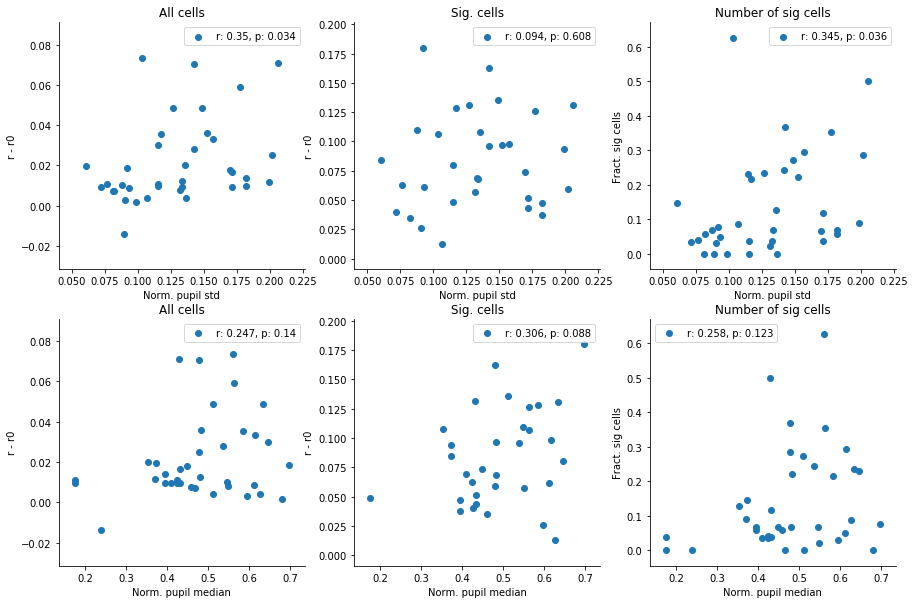

In [7]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].set_xlabel("Norm. pupil std")
ax[0, 0].set_ylabel("r - r0")
ax[0, 0].set_title("All cells")
x = fmod['p_norm_std']
y = fmod['rdiff_mag']
r, p = ss.pearsonr(x, y)
ax[0, 0].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
ax[0, 0].legend()

ax[0, 1].set_xlabel("Norm. pupil std")
ax[0, 1].set_ylabel("r - r0")
ax[0, 1].set_title("Sig. cells")
x = fmod['p_norm_std'][fmod['nSig']>0]
y = fmod['rdiff_mag_sig'][fmod['nSig']>0]
r, p = ss.pearsonr(x, y)
ax[0, 1].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
ax[0, 1].legend()

ax[0, 2].set_xlabel("Norm. pupil std")
ax[0, 2].set_ylabel("Fract. sig cells")
ax[0, 2].set_title("Number of sig cells")
x = fmod['p_norm_std']
y = fmod['nSig'] / fmod['nCells']
r, p = ss.pearsonr(x, y)
ax[0, 2].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
ax[0, 2].legend()


ax[1, 0].set_xlabel("Norm. pupil median")
ax[1, 0].set_ylabel("r - r0")
ax[1, 0].set_title("All cells")
x = fmod['p_norm_median']
y = fmod['rdiff_mag']
r, p = ss.pearsonr(x, y)
ax[1, 0].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
ax[1, 0].legend()

ax[1, 1].set_xlabel("Norm. pupil median")
ax[1, 1].set_ylabel("r - r0")
ax[1, 1].set_title("Sig. cells")
x = fmod['p_norm_median'][fmod['nSig']>0]
y = fmod['rdiff_mag_sig'][fmod['nSig']>0]
r, p = ss.pearsonr(x, y)
ax[1, 1].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
ax[1, 1].legend()


ax[1, 2].set_xlabel("Norm. pupil median")
ax[1, 2].set_ylabel("Fract. sig cells")
ax[1, 2].set_title("Number of sig cells")
x = fmod['p_norm_median']
y = fmod['nSig'] / fmod['nCells']
r, p = ss.pearsonr(x, y)
ax[1, 2].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
ax[1, 2].legend()


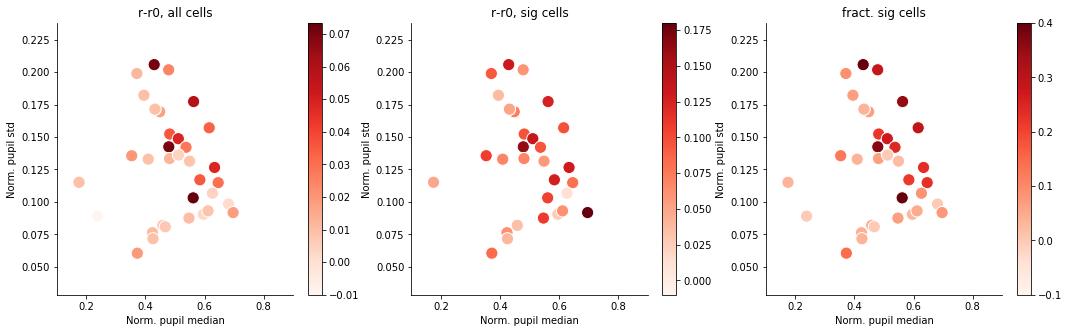

In [4]:
f, ax = plt.subplots(1, 3, figsize=(18, 5))

cm = ax[0].scatter(y=fmod["p_norm_std"], x=fmod["p_norm_median"], c=fmod["rdiff_mag"], cmap="Reds", vmin=-0.01, s=150, edgecolor='white')
ax[0].set_title("r-r0, all cells")
f.colorbar(cm, ax=ax[0])

cm = ax[1].scatter(y=fmod["p_norm_std"], x=fmod["p_norm_median"], c=fmod["rdiff_mag_sig"], cmap="Reds", vmin=-0.01, s=150, edgecolor='white')
ax[1].set_title("r-r0, sig cells")
f.colorbar(cm, ax=ax[1])

cm = ax[2].scatter(y=fmod["p_norm_std"], x=fmod["p_norm_median"], c=fmod["nSig"]/fmod["nCells"], cmap="Reds", vmin=-0.1, vmax=0.4, s=150, edgecolor='white')
ax[2].set_title("fract. sig cells")
f.colorbar(cm, ax=ax[2])

for a in ax:
    a.set_xlabel("Norm. pupil median")
    a.set_ylabel("Norm. pupil std")
    a.set_xlim((0.1, 0.9))

## Load decoding results

In [8]:
# load decoding results
loader = decoding.DecodingResults()
modelname = 'dprime_jk10_zscore_allPup_fixtdr2-fa'
n_components = 2

dfs = []
for idx, site in enumerate(fmod.site):
    batch = fmod.iloc[idx]['batch']
    if batch == 331:
        _modelname = modelname.replace("_allPup", "")
    else:
        _modelname = modelname
    
    fn = os.path.join(DPRIME_DIR, str(batch), site, _modelname+'_TDR.pickle')
    results = loader.load_results(fn)
    df = results.numeric_results; df['delta_dprime'] = (df['bp_dp'] - df['sp_dp']) / (df['bp_dp'] + df['sp_dp']); df['site'] = site; df['batch'] = batch
    dfs.append(df)
df = pd.concat(dfs)

[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM029a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM031a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM032a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM033a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/CRD018d/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle 

## Load noise correlation results

In [9]:
rsc = ld.load_noise_correlation('rsc_ev_perstim', batch=[294, 322, 331])
rsc['delta'] = rsc['sp'] - rsc['bp']

no results found for site: AMT021b, model: rsc_ev_perstim
no results found for site: ARM005e, model: rsc_ev_perstim
no results found for site: CRD005b, model: rsc_ev_perstim
no results found for site: CRD019b, model: rsc_ev_perstim


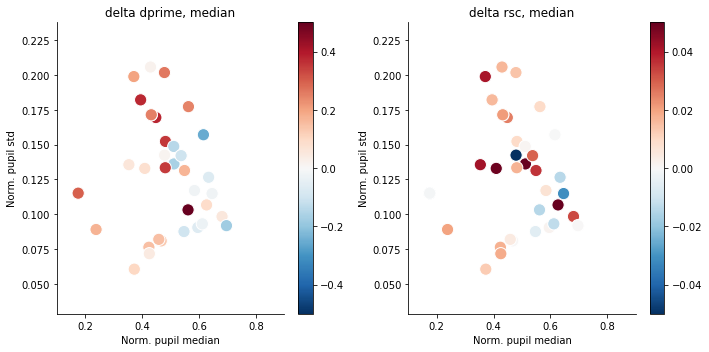

In [10]:
gdelta = df.groupby(by=['site', 'batch']).median()[['delta_dprime']]
gdelta = gdelta.merge(fmod, on=['site', 'batch']).merge(rsc.groupby(by=['site', 'batch']).median(), on=['site', 'batch'])

f, ax = plt.subplots(1, 2, figsize=(10, 5))

cm = ax[0].scatter(y=gdelta["p_norm_std"], x=gdelta["p_norm_median"], c=gdelta["delta_dprime"], cmap="RdBu_r", vmin=-0.5, vmax=0.5, s=150, edgecolor='white')
ax[0].set_title("delta dprime, median")
f.colorbar(cm, ax=ax[0])

ax[0].set_xlabel("Norm. pupil median")
ax[0].set_ylabel("Norm. pupil std")
ax[0].set_xlim((0.1, 0.9))

cm = ax[1].scatter(y=gdelta["p_norm_std"], x=gdelta["p_norm_median"], c=gdelta["delta"], cmap="RdBu_r", vmin=-0.05, vmax=0.05, s=150, edgecolor='white')
ax[1].set_title("delta rsc, median")
f.colorbar(cm, ax=ax[1])

ax[1].set_xlabel("Norm. pupil median")
ax[1].set_ylabel("Norm. pupil std")
ax[1].set_xlim((0.1, 0.9))

f.tight_layout()

In [12]:
fmod.columns

Index(['site', 'batch', 'p_std', 'p_median', 'p_mean', 'p_norm_std',
       'p_norm_median', 'p_norm_mean', 'nCells', 'nSig', 'rdiff_mag',
       'rdiff_mag_sig', 'r_test0_mean'],
      dtype='object')

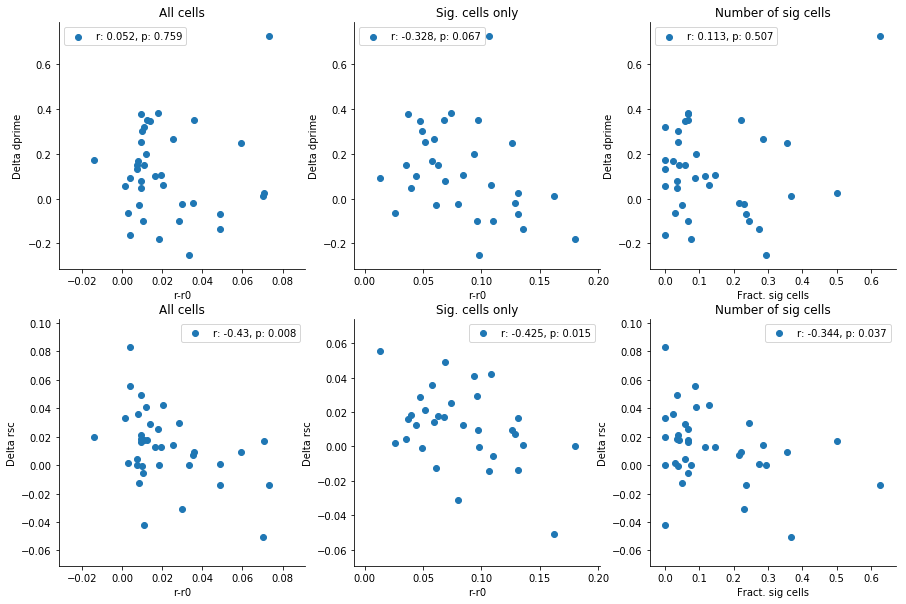

In [18]:
# pop metrics (dprime and rsc) as function of first order effects
f, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, (metric, k) in enumerate(zip(["delta_dprime", "delta"], ["Delta dprime", "Delta rsc"])):
    x = gdelta["rdiff_mag"]
    y = gdelta[metric]
    r, p = ss.pearsonr(x, y)
    ax[i, 0].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
    ax[i, 0].legend()
    ax[i, 0].set_xlabel("r-r0")
    ax[i, 0].set_ylabel(k)
    ax[i, 0].set_title("All cells")

    x = gdelta["rdiff_mag_sig"][gdelta["nSig"]>0]
    y = gdelta[metric][gdelta["nSig"]>0]
    r, p = ss.pearsonr(x, y)
    ax[i, 1].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
    ax[i, 1].legend()
    ax[i, 1].set_xlabel("r-r0")
    ax[i, 1].set_ylabel(k)
    ax[i, 1].set_title("Sig. cells only")

    x = gdelta["nSig"] / gdelta["nCells"]
    y = gdelta[metric]
    r, p = ss.pearsonr(x, y)
    ax[i, 2].scatter(x, y, label=f"r: {round(r, 3)}, p: {round(p, 3)}")
    ax[i, 2].legend()
    ax[i, 2].set_xlabel("Fract. sig cells")
    ax[i, 2].set_ylabel(k)
    ax[i, 2].set_title("Number of sig cells")

In [27]:
gsites = fmod[(fmod["p_norm_std"]>.1) & (fmod["p_norm_median"]<0.6)].site
#gsites = fmod[(fmod["p_norm_median"]<0.6)].site

## Load LV dprime results

In [28]:
decoder = 'dprime_jk10_zscore_allPup_fixtdr2-fa'
rlv = 'psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0.ss3'
ind = 'psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.SxR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0.ss3'
plv = 'psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.SxR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0.ss3'
plv2 = 'psth.fs4.pup-ld-st.pup.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.SxR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0.ss3'

recache = False
results = {
    'fit': {
        'pup_indep': [],
        'indep_noise': [],
        'lv': [],
        'lv2': [],
        'raw': []
    },
    'val': {
        'pup_indep': [],
        'indep_noise': [],
        'lv': [],
        'lv2': [],
        'raw': []
    }
}
for i, site in enumerate(fmod.site):
    if site not in gsites.values:
        continue
    batch = fmod.iloc[i]['batch']
    if batch != 331:
        _rlv = rlv.replace('-epcpn', '')
        _ind = ind.replace('-epcpn', '')
        _plv = plv.replace('-epcpn', '')
        _plv2 = plv2.replace('-epcpn', '')
        _decoder = decoder
    else:
        _rlv = rlv
        _ind = ind
        _plv = plv
        _plv2 = plv2
        _decoder = decoder.replace('_allPup', '')
    
    loader = decoding.DecodingResults()
    fn = os.path.join(DPRIME_DIR, str(batch), site, _decoder+'_TDR.pickle')
    raw = loader.load_results(fn, cache_path=None, recache=recache)
    fn = os.path.join(DPRIME_DIR, str(batch), site, _decoder+f'_model-LV-{_rlv}_TDR.pickle')
    lv0 = loader.load_results(fn, cache_path=None, recache=recache)
    fn = os.path.join(DPRIME_DIR, str(batch), site, _decoder+f'_model-LV-{_ind}_TDR.pickle')
    indep = loader.load_results(fn, cache_path=None, recache=recache)
    fn = os.path.join(DPRIME_DIR, str(batch), site, _decoder+f'_model-LV-{_plv}_TDR.pickle')
    lv = loader.load_results(fn, cache_path=None, recache=recache)
    fn = os.path.join(DPRIME_DIR, str(batch), site, _decoder+f'_model-LV-{_plv2}_TDR.pickle')
    lv2 = loader.load_results(fn, cache_path=None, recache=recache)

    # get the epochs of interest (fit epochs)
    mask_bins = lv.meta['mask_bins']
    fit_combos = [k for k, v in lv.mapping.items() if (('_'.join(v[0].split('_')[:-1]), int(v[0].split('_')[-1])) in mask_bins) & \
                                                        (('_'.join(v[1].split('_')[:-1]), int(v[1].split('_')[-1])) in mask_bins)]
    all_combos = lv.evoked_stimulus_pairs
    val_combos = [c for c in all_combos if c not in fit_combos]

    for k, res in zip(['pup_indep', 'indep_noise', 'lv', 'lv2', 'raw'], [lv0, indep, lv, lv2, raw]):
        df = res.numeric_results
        df['delta'] = (df['bp_dp'] - df['sp_dp']) / (df['bp_dp'] + df['sp_dp']) #(raw.numeric_results['bp_dp'] + raw.numeric_results['sp_dp'])
        df['raw_delta'] = (df['bp_dp'] - df['sp_dp'])
        df['site'] = site
        results['fit'][k].append(df.loc[fit_combos])
        results['val'][k].append(df.loc[val_combos])

# concatenate data frames
for k in results['fit'].keys():
    results['fit'][k] = pd.concat(results['fit'][k])
    results['val'][k] = pd.concat(results['val'][k])


[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_model-LV-psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.2xR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0.ss3_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_model-LV-psth.fs4.pup-ld-st.pup0.pvp-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-lvnorm.2xR.so-inoise.SxR_tfinit.xx0.n.lr1e4.cont.et5.i50000-lvnoise.r8-aev-ccnorm.t5.f0.ss3_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_model-LV-psth.fs4.pup-ld-st.pup.pvp0-epcpn-hrc-psthfr.z-plgsm.er5-aev_stategain.SxR-spred-l

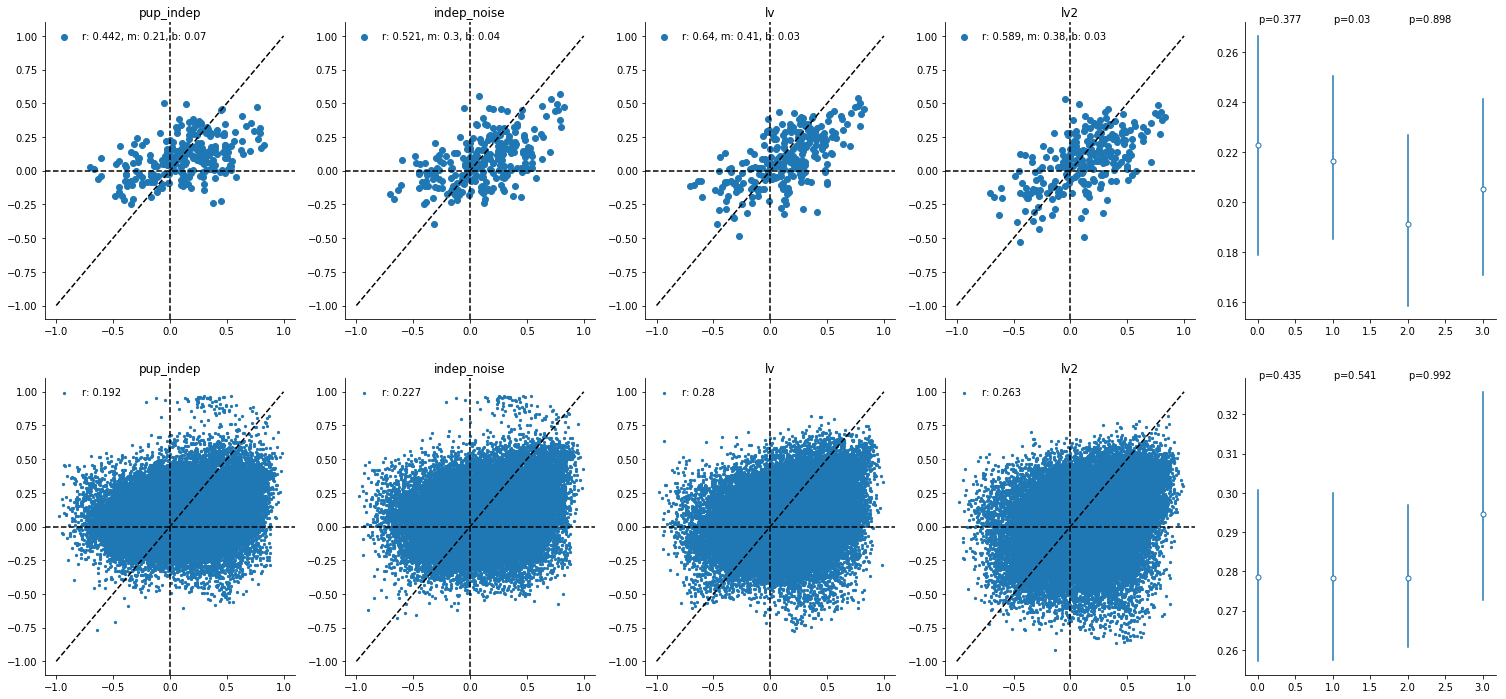

In [29]:
np.random.seed(123)
metric = 'delta'

f, ax = plt.subplots(2, 5, figsize=(26, 12))
err = {}
err_val = {}
col = "tab:blue"
for i, mn in enumerate(results['fit'].keys()):
    if mn!='raw':
        x = results['fit']['raw'][metric]
        y = results['fit'][mn][metric]
        m, b = np.polyfit(x, y, 1)
        lab = f"r: {round(np.corrcoef(x, y)[0, 1], 3)}, m: {round(m, 2)}, b: {round(b, 2)}"
        ax[0, i].scatter(x, y, label=lab, color=col)
        ax[0, i].set_title(mn)
        if 1: #j == 0:
            ax[0, i].plot([-1, 1], [-1, 1], 'k--')
            ax[0, i].axhline(0, linestyle='--', color='k'); ax[0, i].axvline(0, linestyle='--', color='k') 
        if 1: #j == 0:
            ax[0, i].legend(frameon=False, fontsize=10) 

        r = results["fit"]["raw"]
        pr = results["fit"][mn]
        d = {s: np.abs(r[r.site==s][metric]-pr[pr.site==s][metric]).values for s in r.site.unique()}
        err[mn] = d
        bootsamp = get_bootstrapped_sample(d, metric='mean', even_sample=False, nboot=1000)
        low = np.quantile(bootsamp, .025)
        high = np.quantile(bootsamp, .975)

        ax[0, 4].scatter(i, np.mean(bootsamp), color='white', edgecolor=col, s=25)
        ax[0, 4].plot([i, i], [low, high], zorder=-1, color=col)

        x = results['val']['raw'][metric]
        y = results['val'][mn][metric]
        lab = f"r: {round(np.corrcoef(x, y)[0, 1], 3)}"
        ax[1, i].scatter(x, y, label=lab, s=5, color=col)
        ax[1, i].set_title(mn)
        if 1: #j == 0:
            ax[1, i].plot([-1, 1], [-1, 1], 'k--')
            ax[1, i].axhline(0, linestyle='--', color='k'); ax[1, i].axvline(0, linestyle='--', color='k') 
        if 1: #j == 0:
            ax[1, i].legend(frameon=False, fontsize=10) 

        r = results["val"]["raw"]
        pr = results["val"][mn]
        d = {s: np.abs(r[r.site==s][metric]-pr[pr.site==s][metric]).values for s in r.site.unique()}
        err_val[mn] = d
        bootsamp = get_bootstrapped_sample(d, metric='mean', even_sample=False, nboot=1000)
        low = np.quantile(bootsamp, .025)
        high = np.quantile(bootsamp, .975)

        ax[1, 4].scatter(i, np.mean(bootsamp), color='white', edgecolor=col, s=25)
        ax[1, 4].plot([i, i], [low, high], zorder=-1, color=col)

for i, pair in enumerate([['pup_indep', 'indep_noise'], ['indep_noise', 'lv'], ['lv', 'lv2']]):
    d = {s: err[pair[0]][s]-err[pair[1]][s] for s in err[pair[1]].keys()}
    bootsamp = get_bootstrapped_sample(d, metric='mean', even_sample=False, nboot=1000)
    p = get_direct_prob(bootsamp, np.zeros(len(bootsamp)))[0]
    ax[0, 4].text(i, ax[0, 4].get_ylim()[-1], r"p=$%s$"%round(p, 3), fontsize=10)

    d = {s: err_val[pair[0]][s]-err_val[pair[1]][s] for s in err_val[pair[1]].keys()}
    bootsamp = get_bootstrapped_sample(d, metric='mean', even_sample=False, nboot=1000)
    p = get_direct_prob(bootsamp, np.zeros(len(bootsamp)))[0]
    ax[1, 4].text(i, ax[1, 4].get_ylim()[-1], r"p=$%s$"%round(p, 3), fontsize=10)
